# Description

This notebooks performs QA checks for a single vendor:
   - Number of NaN data points as % of total
   - Number of data points where `volume=0` as % of total

# Imports

In [1]:
import logging
import os

import core.config.config_ as cconconf
import core.config.config_utils as ccocouti
import helpers.hdbg as hdbg
import helpers.henv as henv
import helpers.hprint as hprint
import helpers.hs3 as hs3
import im_v2.ccxt.data.client as icdcl
import research_amp.cc.qa as ramccqa

/app/helpers/hparquet.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
hdbg.init_logger(verbosity=logging.INFO)

_LOG = logging.getLogger(__name__)

_LOG.info("%s", henv.get_system_signature()[0])

hprint.config_notebook()

INFO: > cmd='/venv/lib/python3.8/site-packages/ipykernel_launcher.py -f /home/.local/share/jupyter/runtime/kernel-090617ee-998d-4716-ae7d-eb211cd34114.json'
INFO  # Git
    branch_name='CmTask1999_move_plot_bad_data_by_year_month'
    hash='762540791'
    # Last commits:
      * 762540791 Nina Lee Cm task1999 update compare data calls in the notebooks (#2040)    (88 minutes ago) Wed Jun 1 15:10:50 2022  (HEAD -> CmTask1999_move_plot_bad_data_by_year_month, origin/master, origin/HEAD, master)
      * d4aab52c5 cryptomtc AmpTask1786_Integrate_20220531 (#2045)                            (   2 hours ago) Wed Jun 1 14:27:35 2022           
      * bf8761a75 Daniil Tikhomirov CMTask2043: Update parquet files merging (#2049)                  (   3 hours ago) Wed Jun 1 13:48:36 2022           
# Machine info
    system=Linux
    node name=338f016b0bee
    release=5.13.0-1022-aws
    version=#24~20.04.1-Ubuntu SMP Thu Apr 7 22:10:15 UTC 2022
    machine=x86_64
    processor=x86_64
    cpu count

# Configs

In [3]:
def get_master_single_vendor_qa_config() -> cconconf.Config:
    """
    Get task1866-specific config.
    """
    config = cconconf.Config()
    param_dict = {
        "data": {
            # Parameters for client initialization.
            "im_client": {
                "universe_version": "v3",
                "resample_1min": False,
                "root_dir": os.path.join(
                    hs3.get_s3_bucket_path("ck"), "reorg", "historical.manual.pq"
                ),
                "partition_mode": "by_year_month",
                "dataset": "ohlcv",
                "contract_type": "spot",
                "aws_profile": "ck",
            },
            # Parameters for data query.
            "read_data": {
                "start_ts": None,
                "end_ts": None,
                "columns": ["full_symbol", "close", "volume"],
                "filter_data_mode": "assert",
            },
        },
        "column_names": {
            "full_symbol": "full_symbol",
            "close_price": "close",
        },
        "stats": {
            "threshold": 30,
        },
    }
    config = cconfig.Config.from_dict(param_dict)
    return config

In [4]:
config = get_master_single_vendor_qa_config()
print(config)

data:
  im_client:
    universe_version: v3
    resample_1min: False
    root_dir: s3://cryptokaizen-data/reorg/historical.manual.pq
    partition_mode: by_year_month
    aws_profile: ck
  read_data:
    start_ts: None
    end_ts: None
    columns: ['full_symbol', 'close', 'volume']
    filter_data_mode: assert
column_names:
  full_symbol: full_symbol
  close_price: close
stats:
  threshold: 30


# QA checks

Major metric for a QA check is `"bad data [%]"` which is the sum of `"volume=0 [%]"` and `"NaNs [%]"`.

In [5]:
client = icdcl.CcxtHistoricalPqByTileClient(**config["data"]["im_client"])

In [6]:
universe = client.get_universe()
universe

['binance::ADA_USDT',
 'binance::AVAX_USDT',
 'binance::BNB_USDT',
 'binance::BTC_USDT',
 'binance::DOGE_USDT',
 'binance::EOS_USDT',
 'binance::ETH_USDT',
 'binance::LINK_USDT',
 'binance::SOL_USDT',
 'ftx::BNB_USDT',
 'ftx::BTC_USDT',
 'ftx::DOGE_USDT',
 'ftx::ETH_USDT',
 'ftx::LINK_USDT',
 'ftx::SOL_USDT',
 'ftx::XRP_USDT',
 'gateio::ADA_USDT',
 'gateio::AVAX_USDT',
 'gateio::BNB_USDT',
 'gateio::BTC_USDT',
 'gateio::DOGE_USDT',
 'gateio::EOS_USDT',
 'gateio::ETH_USDT',
 'gateio::FIL_USDT',
 'gateio::LINK_USDT',
 'gateio::SOL_USDT',
 'gateio::XRP_USDT',
 'kucoin::ADA_USDT',
 'kucoin::AVAX_USDT',
 'kucoin::BNB_USDT',
 'kucoin::BTC_USDT',
 'kucoin::DOGE_USDT',
 'kucoin::EOS_USDT',
 'kucoin::ETH_USDT',
 'kucoin::FIL_USDT',
 'kucoin::LINK_USDT',
 'kucoin::SOL_USDT',
 'kucoin::XRP_USDT']

## Binance

In [7]:
binance_universe = [
    full_symbol for full_symbol in universe if full_symbol.startswith("binance")
]
binance_universe

['binance::ADA_USDT',
 'binance::AVAX_USDT',
 'binance::BNB_USDT',
 'binance::BTC_USDT',
 'binance::DOGE_USDT',
 'binance::EOS_USDT',
 'binance::ETH_USDT',
 'binance::LINK_USDT',
 'binance::SOL_USDT']

In [8]:
binance_data = client.read_data(binance_universe, **config["data"]["read_data"])
binance_data.head(3)

,full_symbol,close,volume
timestamp,,,
2018-08-17 00:00:00+00:00,binance::ADA_USDT,0.09479,41334.200000
2018-08-17 00:00:00+00:00,binance::BNB_USDT,9.77780,520.660000
2018-08-17 00:00:00+00:00,binance::BTC_USDT,6311.64000,9.967395


In [9]:
vendor_name = "CCXT"
binance_timestamp_stats = ramccqa.get_timestamp_stats(binance_data, vendor_name)
binance_timestamp_stats

,min_timestamp,max_timestamp,days_available
binance::ADA_USDT,2018-08-17 00:00:00+00:00,2022-05-06 13:43:00+00:00,1358
binance::AVAX_USDT,2020-09-22 06:30:00+00:00,2022-05-06 13:46:00+00:00,591
binance::BNB_USDT,2018-08-17 00:00:00+00:00,2022-05-06 13:49:00+00:00,1358
binance::BTC_USDT,2018-08-17 00:00:00+00:00,2022-05-06 13:53:00+00:00,1358
binance::DOGE_USDT,2019-07-05 12:00:00+00:00,2022-05-06 13:56:00+00:00,1036
binance::EOS_USDT,2018-08-17 00:00:00+00:00,2022-05-06 13:59:00+00:00,1358
binance::ETH_USDT,2018-08-17 00:00:00+00:00,2022-05-06 14:02:00+00:00,1358
binance::LINK_USDT,2019-01-16 10:00:00+00:00,2022-05-06 14:05:00+00:00,1206
binance::SOL_USDT,2020-08-11 06:00:00+00:00,2022-05-06 14:08:00+00:00,633


In [10]:
agg_level_full_symbol = ["full_symbol"]
binance_bad_data_stats = ramccqa.get_bad_data_stats(
    binance_data, agg_level_full_symbol, vendor_name
)
binance_bad_data_stats

,bad data [%],missing bars [%],volume=0 [%],NaNs [%]
binance::ADA_USDT,2.974477,0.237177,2.737300,0.0
binance::AVAX_USDT,4.644870,0.157843,4.487027,0.0
binance::BNB_USDT,0.528638,0.237176,0.291461,0.0
binance::BTC_USDT,0.248166,0.237125,0.011041,0.0
binance::DOGE_USDT,24.081726,0.200341,23.881385,0.0
binance::EOS_USDT,0.917571,0.237175,0.680396,0.0
binance::ETH_USDT,0.251385,0.237175,0.014210,0.0
binance::LINK_USDT,7.336060,0.230873,7.105187,0.0
binance::SOL_USDT,2.572014,0.147367,2.424647,0.0


In [11]:
agg_level_full_symbol_year_month = ["full_symbol", "year", "month"]
binance_bad_data_stats_by_year_month = ramccqa.get_bad_data_stats(
    binance_data, agg_level_full_symbol_year_month, vendor_name
)
binance_bad_data_stats_by_year_month

bad data [%]  missing bars [%]  volume=0 [%]  NaNs [%]
binance::ADA_USDT  2018 8       0.138889          0.000000      0.138889       0.0
                        9       0.192130          0.000000      0.192130       0.0
                        10      1.624104          0.470430      1.153674       0.0
                        11      1.951389          0.972222      0.979167       0.0
                        12      1.384409          0.000000      1.384409       0.0
                   2019 1       2.275986          0.000000      2.275986       0.0
                        2       4.503968          0.000000      4.503968       0.0
                        3       3.163082          0.806452      2.356631       0.0
                        4       2.171296          0.000000      2.171296       0.0
                        5       6.538978          1.344086      5.194892       0.0
                        6       3.296296          0.141204      3.155093       0.0
                        7       8.969534          0.000000      8.969534       0.0
                        8      15.152330          1.075269     14.077061       0.0
                        9      12.159722          0.000000     12.159722       0.0
                        10     10.000000          0.000000     10.000000       0.0
                        11      7.930556          0.608796      7.321759       0.0
                        12     24.117384          0.000000     24.117384       0.0
                   2020 1      10.418907          0.000000     10.418907       0.0
                        2       2.136015          0.991379      1.144636       0.0
                        3       2.650090          0.286738      2.363351       0.0
                        4       4.296296          0.347222      3.949074       0.0
                        5       1.326165          0.000000      1.326165       0.0
                        6       1.168981          0.486111      0.682870       0.0
                        7       0.136649          0.000000      0.136649       0.0
                        8       0.073925          0.000000      0.073925       0.0
                        9       0.210648          0.000000      0.210648       0.0
                        10      0.602599          0.000000      0.602599       0.0
                        11      0.305556          0.138889      0.166667       0.0
                        12      0.768369          0.651882      0.116487       0.0
                   2021 1       0.015681          0.000000      0.015681       0.0
                        2       0.396825          0.195933      0.200893       0.0
                        3       0.201613          0.201613      0.000000       0.0
                        4       1.004630          1.004630      0.000000       0.0
                        5       0.000000          0.000000      0.000000       0.0
                        6       0.000000          0.000000      0.000000       0.0
                        7       0.000000          0.000000      0.000000       0.0
                        8       0.604839          0.604839      0.000000       0.0
                        9       0.277778          0.277778      0.000000       0.0
                        10      0.000000          0.000000      0.000000       0.0
                        11      0.000000          0.000000      0.000000       0.0
                        12      0.000000          0.000000      0.000000       0.0
                   2022 1       0.000000          0.000000      0.000000       0.0
                        2       0.000000          0.000000      0.000000       0.0
                        3       0.002240          0.000000      0.002240       0.0
                        4       0.000000          0.000000      0.000000       0.0
                        5       0.000000          0.000000      0.000000       0.0
binance::AVAX_USDT 2020 9       6.229117          0.000000      6.229117       0.0
                        10     30.253136    

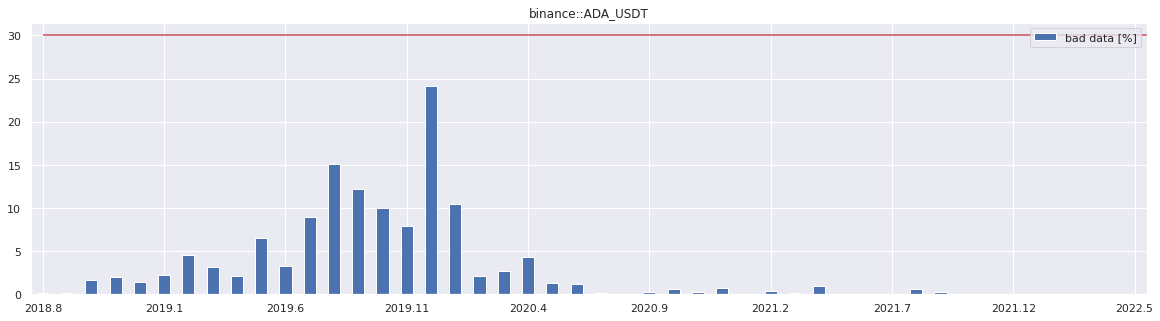

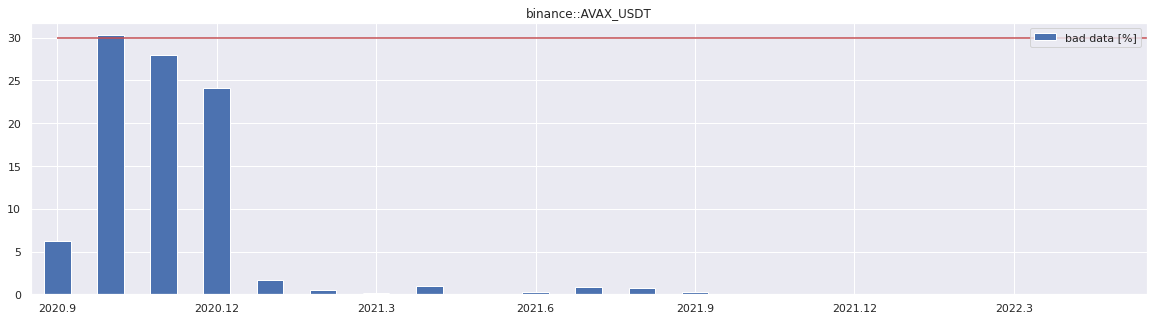

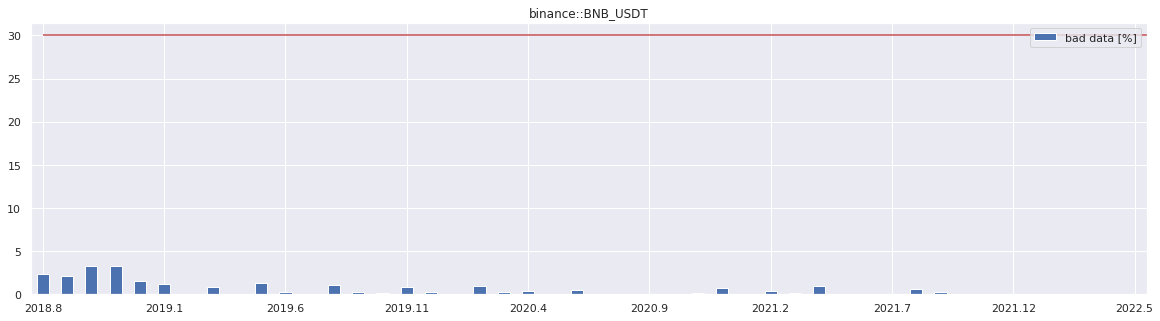

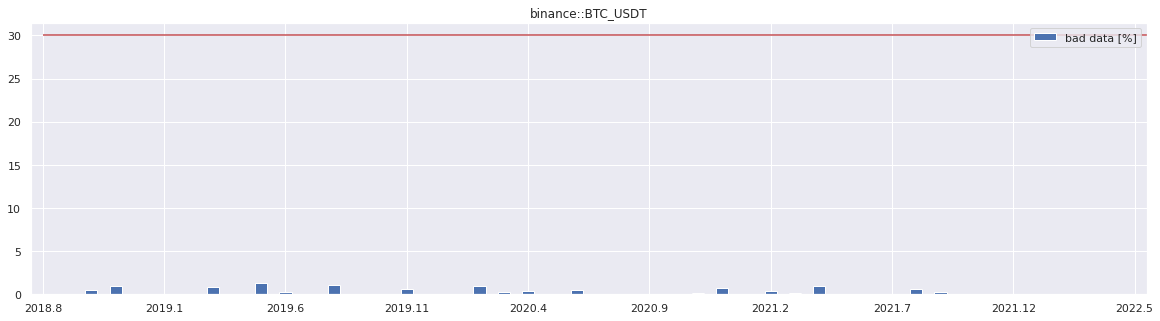

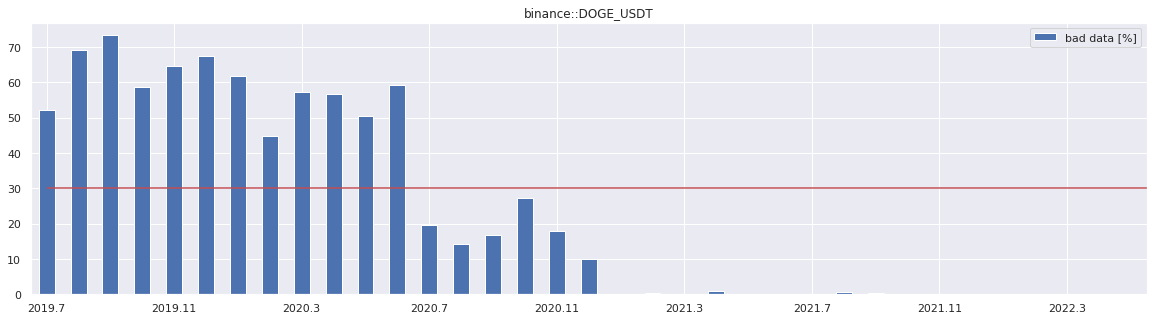

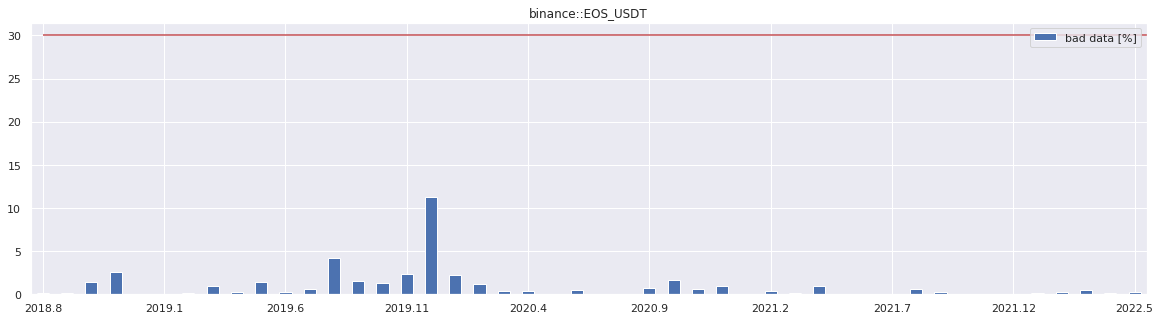

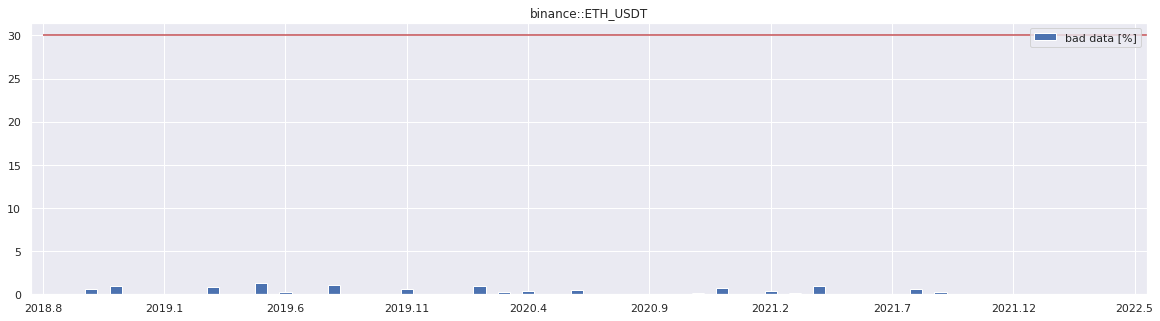

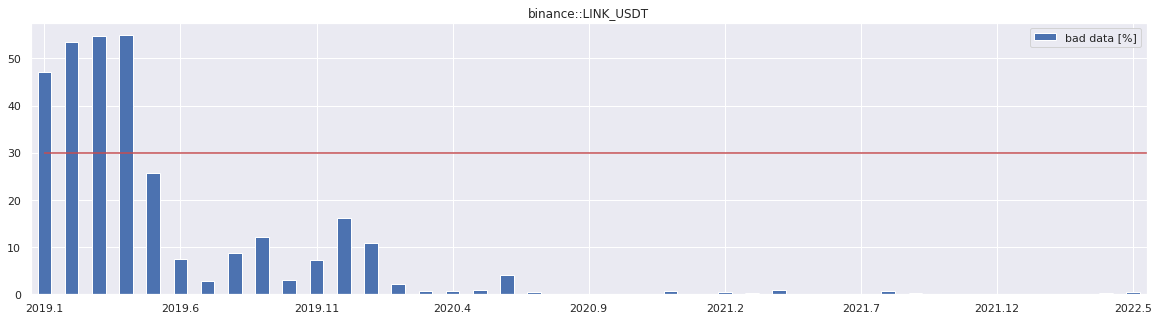

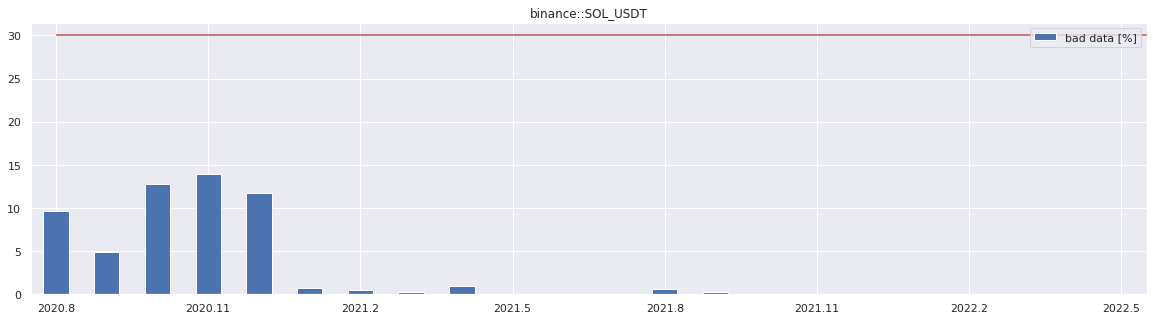

In [12]:
_ = ramccqa.plot_bad_data_by_year_month_stats(
    binance_bad_data_stats_by_year_month, config["stats"]["threshold"]
)

## FTX

In [13]:
ftx_universe = [
    full_symbol for full_symbol in universe if full_symbol.startswith("ftx")
]
ftx_universe

['ftx::BNB_USDT',
 'ftx::BTC_USDT',
 'ftx::DOGE_USDT',
 'ftx::ETH_USDT',
 'ftx::LINK_USDT',
 'ftx::SOL_USDT',
 'ftx::XRP_USDT']

In [14]:
ftx_data = client.read_data(ftx_universe, **config["data"]["read_data"])
ftx_data.head(3)

,full_symbol,close,volume
timestamp,,,
2020-03-28 14:40:00+00:00,ftx::BTC_USDT,6240.000,0.0
2020-03-28 14:40:00+00:00,ftx::ETH_USDT,128.765,0.0
2020-03-28 14:41:00+00:00,ftx::BTC_USDT,6235.750,0.0


In [15]:
ftx_timestamp_stats = ramccqa.get_timestamp_stats(ftx_data, vendor_name)
ftx_timestamp_stats

,min_timestamp,max_timestamp,days_available
ftx::BNB_USDT,2020-04-09 20:55:00+00:00,2022-05-06 14:16:00+00:00,756
ftx::BTC_USDT,2020-03-28 14:40:00+00:00,2022-05-06 14:20:00+00:00,768
ftx::DOGE_USDT,2021-01-13 04:06:00+00:00,2022-05-06 14:23:00+00:00,478
ftx::ETH_USDT,2020-03-28 14:40:00+00:00,2022-05-06 14:27:00+00:00,768
ftx::LINK_USDT,2020-04-21 02:34:00+00:00,2022-05-06 14:31:00+00:00,745
ftx::SOL_USDT,2020-07-27 00:13:00+00:00,2022-05-06 01:39:00+00:00,648
ftx::XRP_USDT,2020-07-19 13:37:00+00:00,2022-05-06 14:38:00+00:00,656


In [16]:
ftx_bad_data_stats = ramccqa.get_bad_data_stats(
    ftx_data, agg_level_full_symbol, vendor_name
)
ftx_bad_data_stats

,bad data [%],missing bars [%],volume=0 [%],NaNs [%]
ftx::BNB_USDT,38.994954,0.025420,38.969534,0.0
ftx::BTC_USDT,13.935635,0.024202,13.911433,0.0
ftx::DOGE_USDT,32.836191,0.016838,32.819354,0.0
ftx::ETH_USDT,14.139909,0.024112,14.115797,0.0
ftx::LINK_USDT,45.041536,0.025058,45.016479,0.0
ftx::SOL_USDT,36.770834,0.026468,36.744366,0.0
ftx::XRP_USDT,40.807789,0.026675,40.781114,0.0


In [17]:
ftx_bad_data_stats_by_year_month = ramccqa.get_bad_data_stats(
    ftx_data, agg_level_full_symbol_year_month, vendor_name
)
ftx_bad_data_stats_by_year_month

bad data [%]  missing bars [%]  volume=0 [%]  NaNs [%]
ftx::BNB_USDT  2020 4      89.078061          0.000000     89.078061       0.0
                    5      98.400538          0.022401     98.378136       0.0
                    6      92.442130          0.011574     92.430556       0.0
                    7      76.698029          0.008961     76.689068       0.0
                    8      73.685036          0.114247     73.570789       0.0
                    9      50.548611          0.002315     50.546296       0.0
                    10     64.614695          0.051523     64.563172       0.0
                    11     66.513889          0.159722     66.354167       0.0
                    12     69.910394          0.000000     69.910394       0.0
               2021 1      88.463262          0.000000     88.463262       0.0
                    2      43.851687          0.084325     43.767361       0.0
                    3      37.573925          0.006720     37.567204       0.0
                    4       9.655093          0.006944      9.648148       0.0
                    5      16.066308          0.011201     16.055108       0.0
                    6      29.875000          0.000000     29.875000       0.0
                    7      18.436380          0.000000     18.436380       0.0
                    8       9.301075          0.000000      9.301075       0.0
                    9       9.414352          0.009259      9.405093       0.0
                    10      4.753584          0.013441      4.740143       0.0
                    11      0.828704          0.002315      0.826389       0.0
                    12      3.864247          0.078405      3.785842       0.0
               2022 1       9.030018          0.031362      8.998656       0.0
                    2      10.617560          0.022321     10.595238       0.0
                    3       7.811380          0.000000      7.811380       0.0
                    4      10.409722          0.000000     10.409722       0.0
                    5      13.168673          0.000000     13.168673       0.0
ftx::BTC_USDT  2020 3      95.799180          0.000000     95.799180       0.0
                    4      85.969907          0.000000     85.969907       0.0
                    5      74.267473          0.022401     74.245072       0.0
                    6      67.567130          0.011574     67.555556       0.0
                    7      31.615143          0.008961     31.606183       0.0
                    8      20.795251          0.116487     20.678763       0.0
                    9       7.893519          0.002315      7.891204       0.0
                    10     13.982975          0.038082     13.944892       0.0
                    11     11.405093          0.157407     11.247685       0.0
                    12     14.101703          0.000000     14.101703       0.0
               2021 1       1.433692          0.000000      1.433692       0.0
                    2       1.755952          0.079365      1.676587       0.0
                    3       1.816756          0.006720      1.810036       0.0
                    4       1.680556          0.006944      1.673611       0.0
                    5       0.369624          0.008961      0.360663       0.0
                    6       0.793981          0.000000      0.793981       0.0
                    7       3.181004          0.000000      3.181004       0.0
                    8       0.400986          0.000000      0.400986       0.0
                    9       0.219907          0.009259      0.210648       0.0
                    10      0.089606          0.013441      0.076165       0.0
                    11      0.034722          0.002315      0.032407       0.0
                    12      0.185932          0.078405      0.107527       0.0
               2022 1       0.219534          0.031362      0.188172       0.0
                    2       0.386905          0.022321      0.364583      

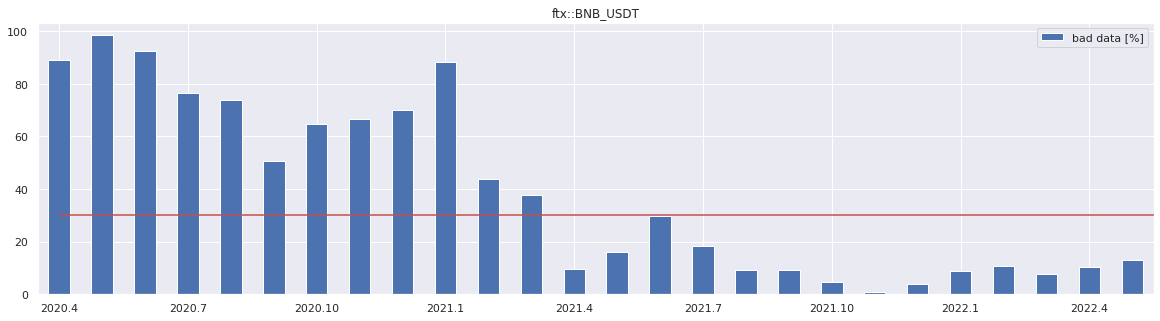

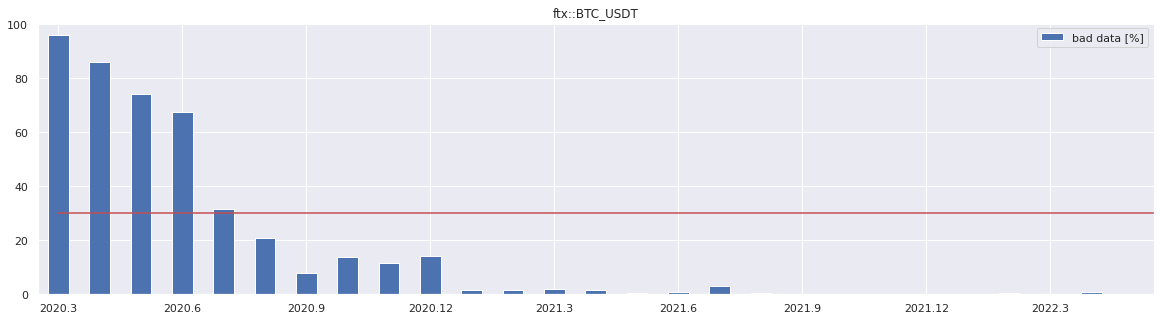

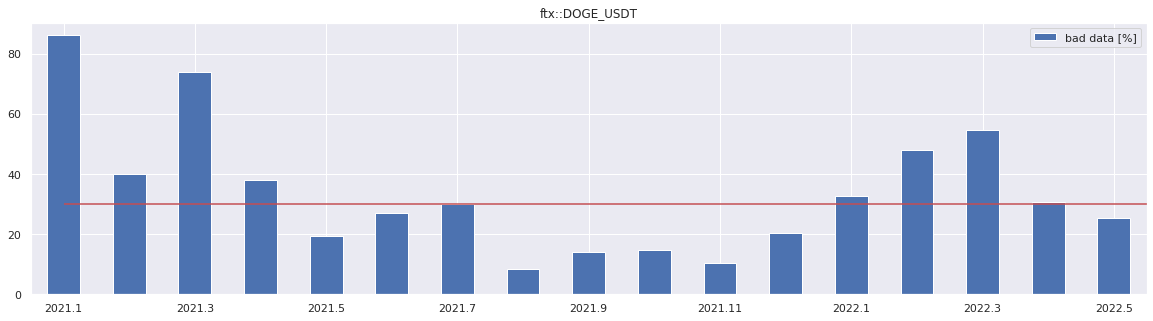

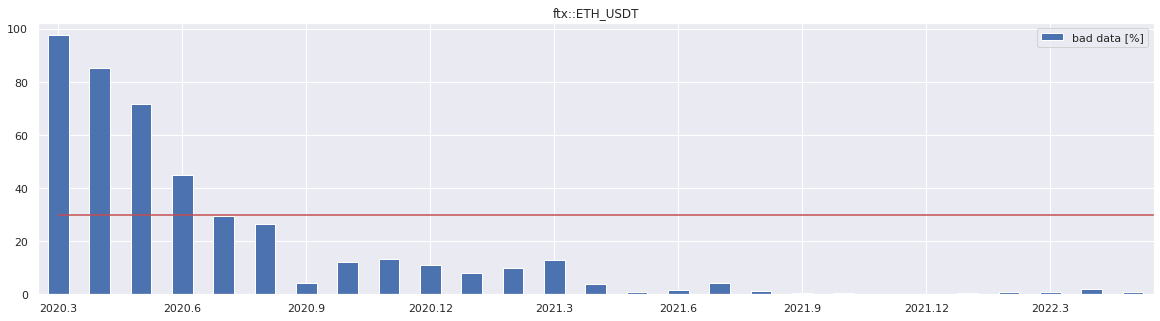

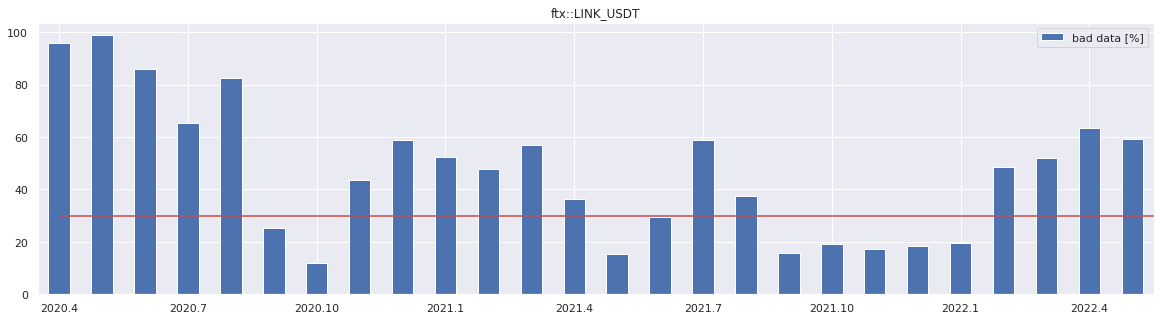

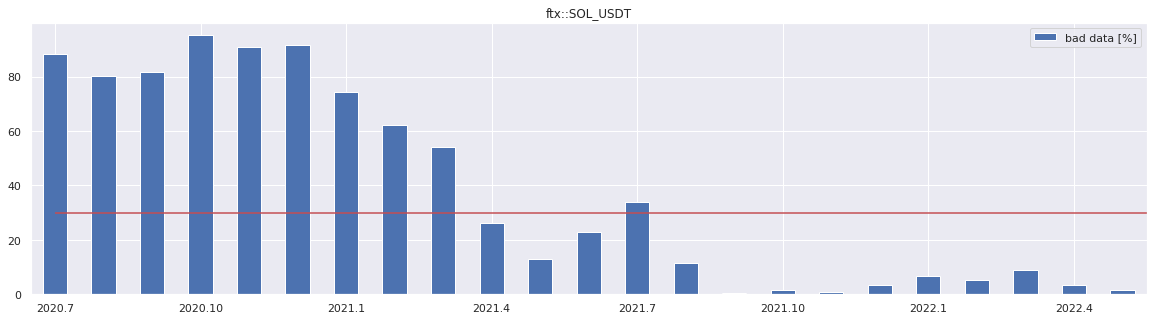

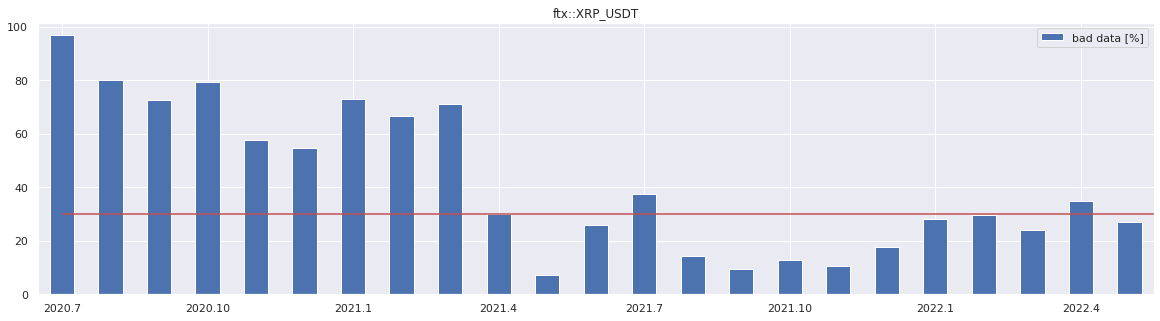

In [18]:
_ = ramccqa.plot_bad_data_by_year_month_stats(
    ftx_bad_data_stats_by_year_month, config["stats"]["threshold"]
)

## Gateio

In [19]:
gateio_universe = [
    full_symbol for full_symbol in universe if full_symbol.startswith("gateio")
]
gateio_universe

['gateio::ADA_USDT',
 'gateio::AVAX_USDT',
 'gateio::BNB_USDT',
 'gateio::BTC_USDT',
 'gateio::DOGE_USDT',
 'gateio::EOS_USDT',
 'gateio::ETH_USDT',
 'gateio::FIL_USDT',
 'gateio::LINK_USDT',
 'gateio::SOL_USDT',
 'gateio::XRP_USDT']

In [20]:
gateio_data = client.read_data(gateio_universe, **config["data"]["read_data"])
gateio_data.head(3)

,full_symbol,close,volume
timestamp,,,
2021-06-22 14:50:00+00:00,gateio::BTC_USDT,30140.88,167073.232956
2021-06-22 14:51:00+00:00,gateio::BTC_USDT,30186.85,221935.631630
2021-06-22 14:52:00+00:00,gateio::BTC_USDT,30258.63,187827.498050


In [21]:
gateio_timestamp_stats = ramccqa.get_timestamp_stats(gateio_data, vendor_name)
gateio_timestamp_stats

,min_timestamp,max_timestamp,days_available
gateio::ADA_USDT,2021-06-22 20:35:00+00:00,2022-05-06 14:43:00+00:00,317
gateio::AVAX_USDT,2021-06-23 00:26:00+00:00,2022-05-06 14:46:00+00:00,317
gateio::BNB_USDT,2021-06-22 22:30:00+00:00,2022-05-06 14:49:00+00:00,317
gateio::BTC_USDT,2021-06-22 14:50:00+00:00,2022-05-06 14:52:00+00:00,318
gateio::DOGE_USDT,2021-06-22 19:38:00+00:00,2022-05-06 14:55:00+00:00,317
gateio::EOS_USDT,2021-06-22 23:28:00+00:00,2022-05-06 14:58:00+00:00,317
gateio::ETH_USDT,2021-06-22 15:48:00+00:00,2022-05-06 15:00:00+00:00,317
gateio::FIL_USDT,2021-06-22 18:40:00+00:00,2022-05-06 15:03:00+00:00,317
gateio::LINK_USDT,2021-06-22 21:33:00+00:00,2022-05-06 15:06:00+00:00,317
gateio::SOL_USDT,2021-06-22 16:45:00+00:00,2022-05-06 15:09:00+00:00,317


In [22]:
gateio_bad_data_stats = ramccqa.get_bad_data_stats(
    gateio_data, agg_level_full_symbol, vendor_name
)
gateio_bad_data_stats

,bad data [%],missing bars [%],volume=0 [%],NaNs [%]
gateio::ADA_USDT,17.043987,16.608424,0.435563,0.0
gateio::AVAX_USDT,20.314601,16.619328,3.695273,0.0
gateio::BNB_USDT,16.637957,16.617628,0.020330,0.0
gateio::BTC_USDT,16.631835,16.626158,0.005678,0.0
gateio::DOGE_USDT,16.807608,16.616409,0.191199,0.0
gateio::EOS_USDT,21.365249,16.627278,4.737971,0.0
gateio::ETH_USDT,16.623168,16.623168,0.000000,0.0
gateio::FIL_USDT,20.193837,16.621878,3.571959,0.0
gateio::LINK_USDT,20.146481,16.630677,3.515804,0.0
gateio::SOL_USDT,22.880795,16.622509,6.258286,0.0


In [23]:
gateio_bad_data_stats_by_year_month = ramccqa.get_bad_data_stats(
    gateio_data, agg_level_full_symbol_year_month, vendor_name
)
gateio_bad_data_stats_by_year_month

bad data [%]  missing bars [%]  volume=0 [%]  NaNs [%]
gateio::ADA_USDT  2021 6       0.110874          0.000000      0.110874       0.0
                       7       0.575717          0.000000      0.575717       0.0
                       8       0.188172          0.000000      0.188172       0.0
                       9      34.363426         34.351852      0.011574       0.0
                       10    100.000000        100.000000      0.000000       0.0
                       11     38.687500         38.229167      0.458333       0.0
                       12      0.322581          0.000000      0.322581       0.0
                  2022 1       0.250896          0.000000      0.250896       0.0
                       2       0.870536          0.000000      0.870536       0.0
                       3       0.658602          0.000000      0.658602       0.0
                       4       0.974537          0.000000      0.974537       0.0
                       5       1.410193          0.000000      1.410193       0.0
gateio::AVAX_USDT 2021 6      20.436750          0.000000     20.436750       0.0
                       7      24.106183          0.000000     24.106183       0.0
                       8       6.758513          0.000000      6.758513       0.0
                       9      34.365741         34.351852      0.013889       0.0
                       10    100.000000        100.000000      0.000000       0.0
                       11     38.291667         38.256944      0.034722       0.0
                       12      0.013441          0.000000      0.013441       0.0
                  2022 1       0.385305          0.000000      0.385305       0.0
                       2       0.515873          0.000000      0.515873       0.0
                       3       0.221774          0.000000      0.221774       0.0
                       4       0.606481          0.000000      0.606481       0.0
                       5       0.061828          0.000000      0.061828       0.0
gateio::BNB_USDT  2021 6       0.000000          0.000000      0.000000       0.0
                       7       0.013441          0.000000      0.013441       0.0
                       8       0.011201          0.000000      0.011201       0.0
                       9      34.354167         34.351852      0.002315       0.0
                       10    100.000000        100.000000      0.000000       0.0
                       11     38.284722         38.284722      0.000000       0.0
                       12      0.000000          0.000000      0.000000       0.0
                  2022 1       0.004480          0.000000      0.004480       0.0
                       2       0.044643          0.000000      0.044643       0.0
                       3       0.053763          0.000000      0.053763       0.0
                       4       0.062500          0.000000      0.062500       0.0
                       5       0.123609          0.000000      0.123609       0.0
gateio::BTC_USDT  2021 6       0.000000          0.000000      0.000000       0.0
                       7       0.004480          0.000000      0.004480       0.0
                       8       0.000000          0.000000      0.000000       0.0
                       9      34.592593         34.592593      0.000000       0.0
                       10    100.000000        100.000000      0.000000       0.0
                       11     38.314815         38.312500      0.002315       0.0
                       12      0.004480          0.000000      0.004480       0.0
                  2022 1       0.002240          0.000000      0.002240       0.0
                       2       0.022321          0.000000      0.022321       0.0
                       3       0.000000          0.000000      0.000000       0.0
                       4       0.023148          0.000000      0.023148       0.0
                       5       0.012356          0.000000      0.012356       0.0
gateio::D

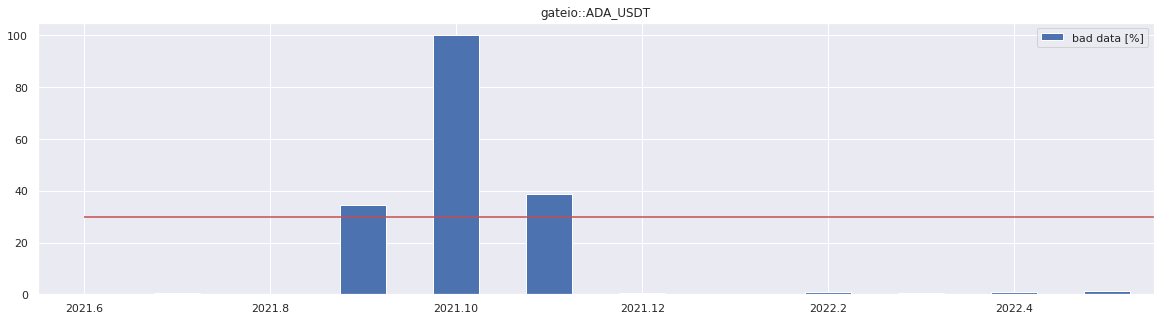

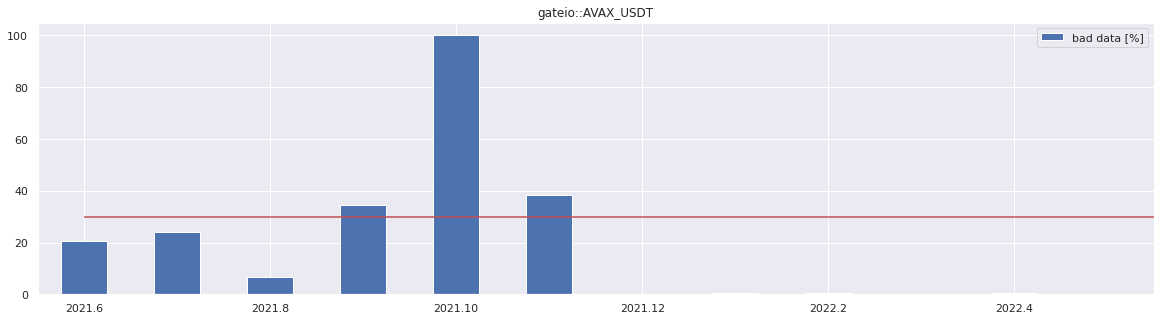

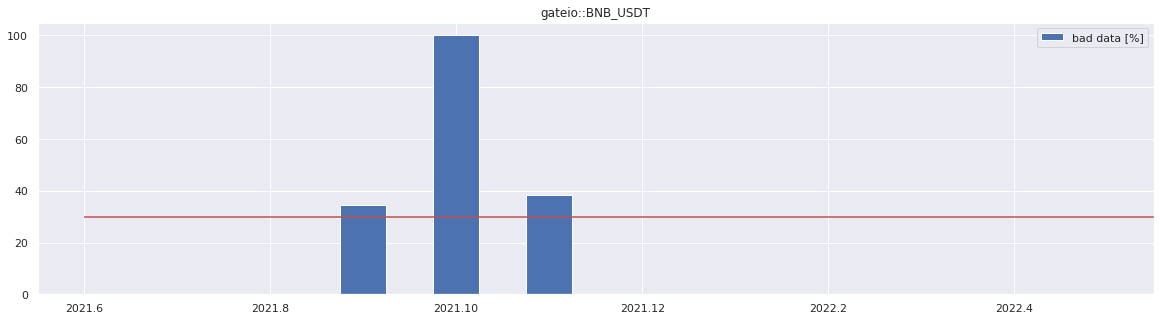

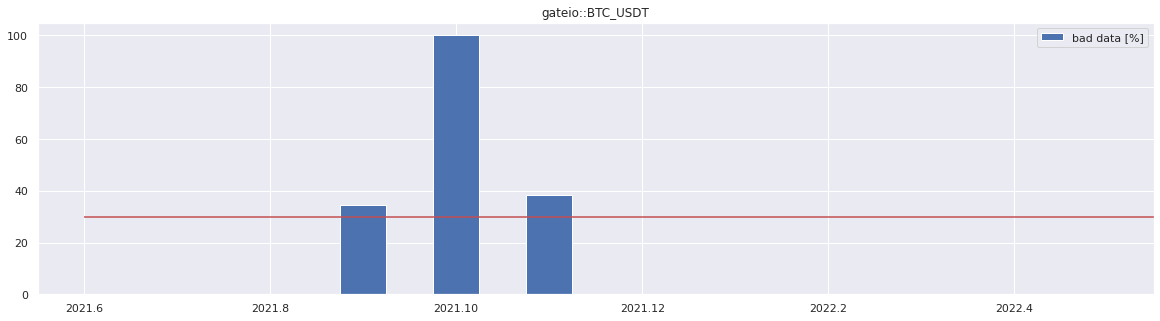

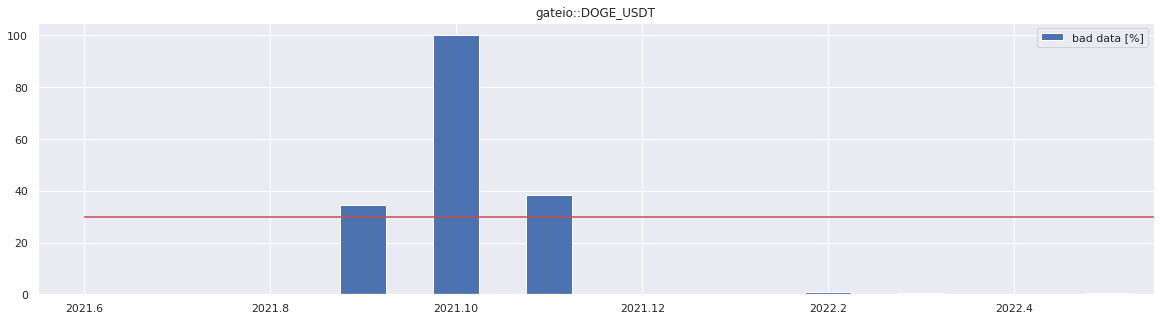

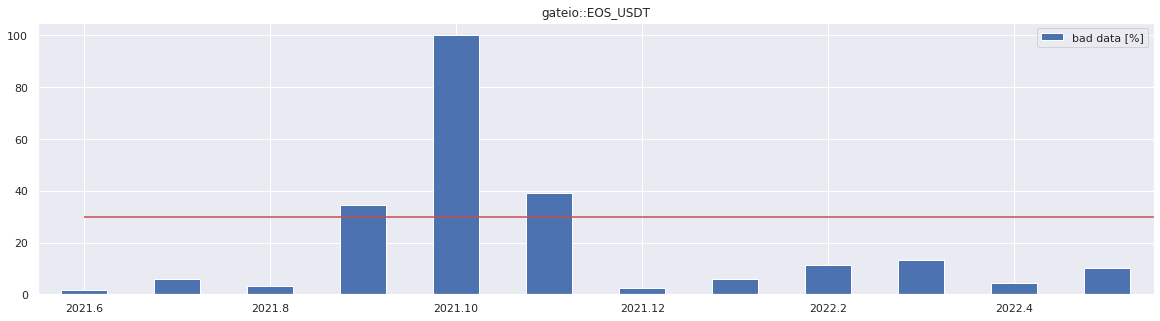

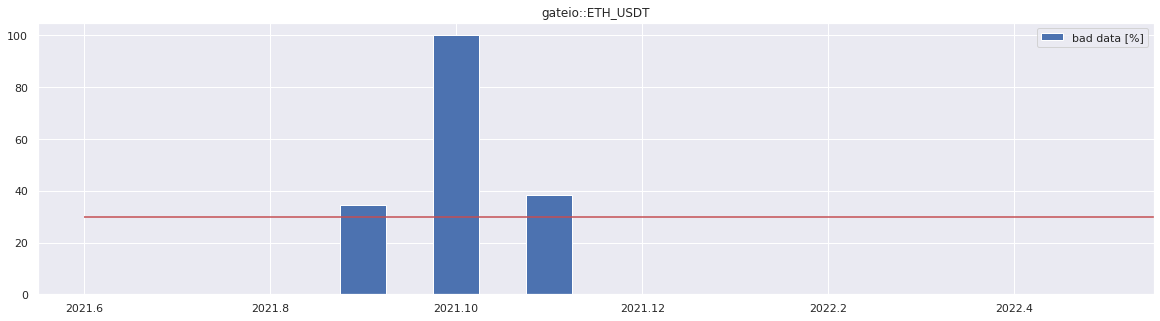

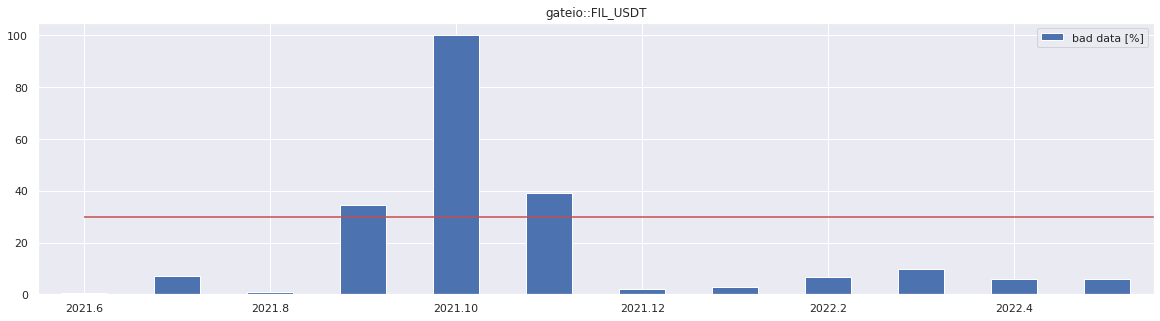

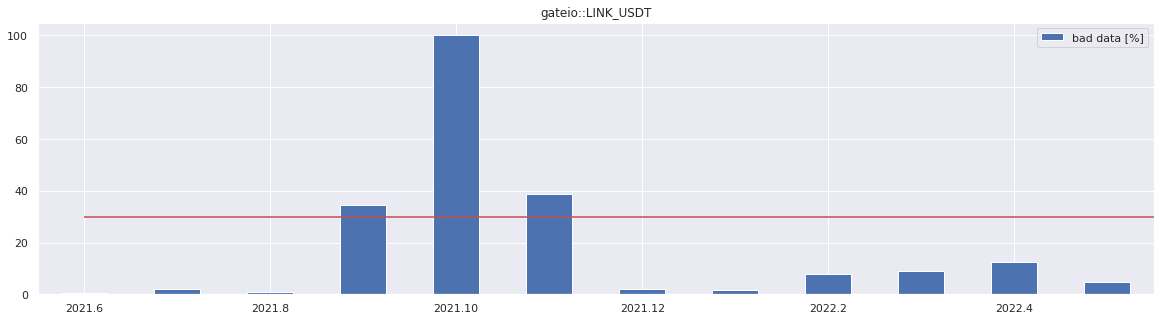

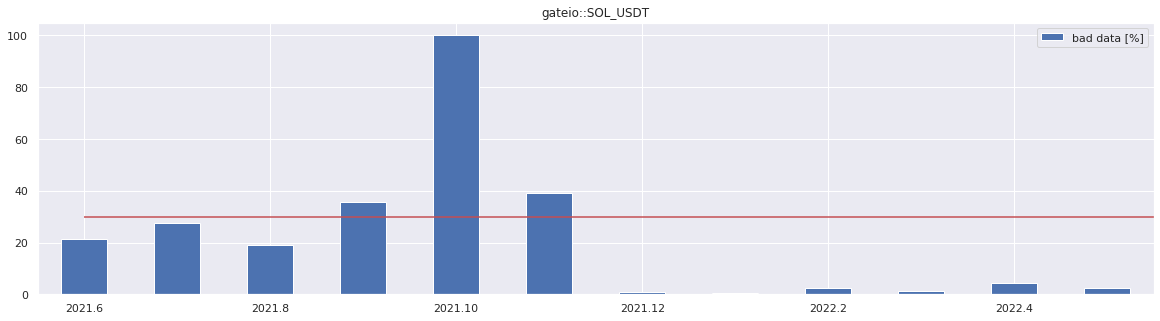

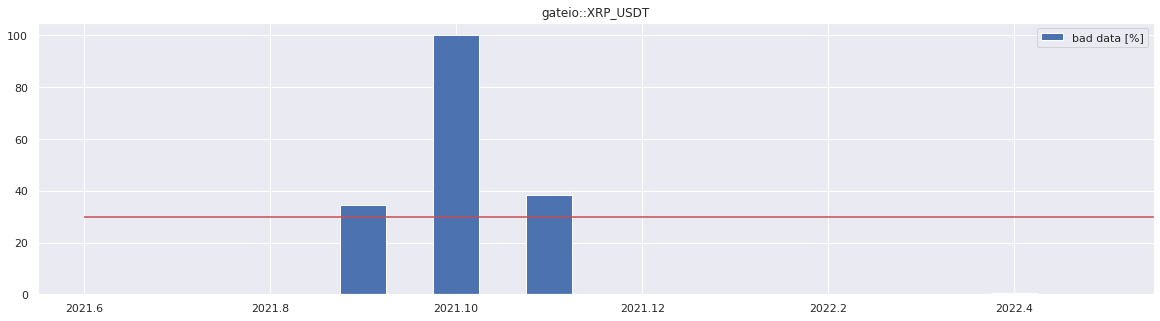

In [24]:
_ = ramccqa.plot_bad_data_by_year_month_stats(
    gateio_bad_data_stats_by_year_month, config["stats"]["threshold"]
)

## Kucoin

In [25]:
kucoin_universe = [
    full_symbol for full_symbol in universe if full_symbol.startswith("kucoin")
]
kucoin_universe

['kucoin::ADA_USDT',
 'kucoin::AVAX_USDT',
 'kucoin::BNB_USDT',
 'kucoin::BTC_USDT',
 'kucoin::DOGE_USDT',
 'kucoin::EOS_USDT',
 'kucoin::ETH_USDT',
 'kucoin::FIL_USDT',
 'kucoin::LINK_USDT',
 'kucoin::SOL_USDT',
 'kucoin::XRP_USDT']

In [26]:
kucoin_data = client.read_data(kucoin_universe, **config["data"]["read_data"])
kucoin_data.head(3)

,full_symbol,close,volume
timestamp,,,
2018-08-17 00:00:00+00:00,kucoin::BTC_USDT,6325.770051,0.025074
2018-08-17 00:01:00+00:00,kucoin::BTC_USDT,6309.204997,0.000871
2018-08-17 00:01:00+00:00,kucoin::ETH_USDT,286.712987,0.017500


In [27]:
kucoin_timestamp_stats = ramccqa.get_timestamp_stats(kucoin_data, vendor_name)
kucoin_timestamp_stats

,min_timestamp,max_timestamp,days_available
kucoin::ADA_USDT,2019-07-04 10:27:00+00:00,2022-02-10 14:32:00+00:00,952
kucoin::AVAX_USDT,2021-03-05 10:00:00+00:00,2022-02-10 14:53:00+00:00,342
kucoin::BNB_USDT,2019-06-19 10:00:00+00:00,2022-02-10 14:56:00+00:00,967
kucoin::BTC_USDT,2018-08-17 00:00:00+00:00,2022-02-10 14:59:00+00:00,1273
kucoin::DOGE_USDT,2021-02-09 03:00:00+00:00,2022-02-10 15:02:00+00:00,366
kucoin::EOS_USDT,2018-08-17 00:10:00+00:00,2022-02-10 15:06:00+00:00,1273
kucoin::ETH_USDT,2018-08-17 00:01:00+00:00,2022-02-10 15:09:00+00:00,1273
kucoin::FIL_USDT,2020-10-15 17:25:00+00:00,2022-02-10 15:12:00+00:00,482
kucoin::LINK_USDT,2020-08-20 10:00:00+00:00,2022-02-10 15:24:00+00:00,539
kucoin::SOL_USDT,2021-08-04 10:00:00+00:00,2022-02-10 15:28:00+00:00,190


In [28]:
kucoin_bad_data_stats = ramccqa.get_bad_data_stats(
    kucoin_data, agg_level_full_symbol, vendor_name
)
kucoin_bad_data_stats

,bad data [%],missing bars [%],volume=0 [%],NaNs [%]
kucoin::ADA_USDT,46.558741,14.319763,32.238977,0.0
kucoin::AVAX_USDT,57.689123,41.630646,16.058477,0.0
kucoin::BNB_USDT,60.489152,14.734591,45.754561,0.0
kucoin::BTC_USDT,17.961145,16.424576,1.536570,0.0
kucoin::DOGE_USDT,41.462171,38.927701,2.534471,0.0
kucoin::EOS_USDT,36.604023,23.847980,12.756043,0.0
kucoin::ETH_USDT,20.213148,17.672403,2.540745,0.0
kucoin::FIL_USDT,54.812709,29.578164,25.234545,0.0
kucoin::LINK_USDT,42.185619,26.442365,15.743253,0.0
kucoin::SOL_USDT,77.271483,75.172764,2.098719,0.0


In [29]:
kucoin_bad_data_stats_by_year_month = ramccqa.get_bad_data_stats(
    kucoin_data, agg_level_full_symbol_year_month, vendor_name
)
kucoin_bad_data_stats_by_year_month

bad data [%]  missing bars [%]  volume=0 [%]  NaNs [%]
kucoin::ADA_USDT  2019 7      79.502683          0.000000     79.502683       0.0
                       8      80.761649          0.000000     80.761649       0.0
                       9      90.444444          0.000000     90.444444       0.0
                       10     90.840054          0.000000     90.840054       0.0
                       11     89.381944          0.000000     89.381944       0.0
                       12     91.648746          0.000000     91.648746       0.0
                  2020 1      78.940412          0.000000     78.940412       0.0
                       2      70.000000          0.000000     70.000000       0.0
                       3      68.700717          0.000000     68.700717       0.0
                       4      68.539352          0.000000     68.539352       0.0
                       5      50.353943          0.000000     50.353943       0.0
                       6      42.590278          0.000000     42.590278       0.0
                       7       7.607527          0.000000      7.607527       0.0
                       8       4.475806          0.000000      4.475806       0.0
                       9      12.881944          0.000000     12.881944       0.0
                       10     25.163530          0.000000     25.163530       0.0
                       11     17.553241          0.000000     17.553241       0.0
                       12     30.396505          0.000000     30.396505       0.0
                  2021 1       8.391577          0.000000      8.391577       0.0
                       2       1.857639          0.000000      1.857639       0.0
                       3       0.456989          0.000000      0.456989       0.0
                       4       0.523148          0.000000      0.523148       0.0
                       5       0.056004          0.000000      0.056004       0.0
                       6       0.599537          0.000000      0.599537       0.0
                       7       2.159498          0.000000      2.159498       0.0
                       8       0.302419          0.000000      0.302419       0.0
                       9      47.196759         47.196759      0.000000       0.0
                       10     93.279570         93.279570      0.000000       0.0
                       11     93.055556         93.055556      0.000000       0.0
                       12     89.921595         89.919355      0.002240       0.0
                  2022 1      93.279570         93.279570      0.000000       0.0
                       2      89.170823         89.156365      0.014458       0.0
kucoin::AVAX_USDT 2021 3      47.317137          0.000000     47.317137       0.0
                       4      29.155093          0.000000     29.155093       0.0
                       5      12.072133          0.000000     12.072133       0.0
                       6      30.349537          0.000000     30.349537       0.0
                       7      48.445341          0.000000     48.445341       0.0
                       8      18.337814          0.000000     18.337814       0.0
                       9      50.412037         50.164352      0.247685       0.0
                       10     96.648746         96.639785      0.008961       0.0
                       11     96.530093         96.527778      0.002315       0.0
                       12     96.639785         96.639785      0.000000       0.0
                  2022 1      96.639785         96.639785      0.000000       0.0
                       2      89.172802         89.172802      0.000000       0.0
kucoin::BNB_USDT  2019 6      74.658273          0.000000     74.658273       0.0
                       7      69.186828          0.000000     69.186828       0.0
                       8      76.910842          0.000000     76.910842       0.0
                       9      82.645833          0.000000     82.645833       0.0
         

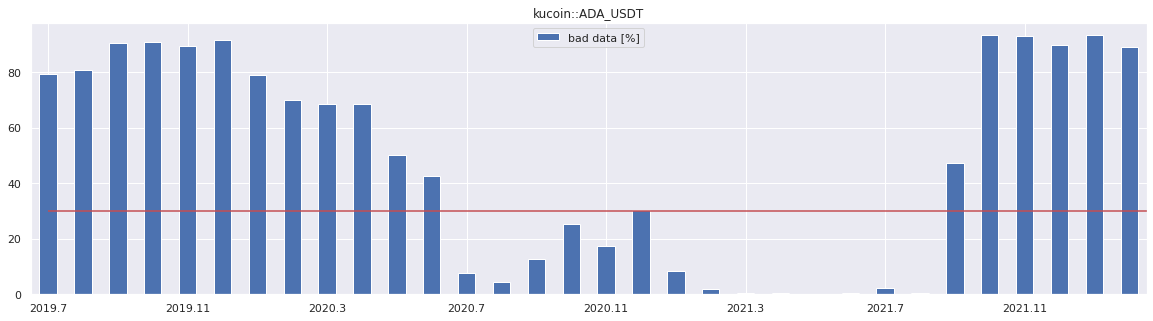

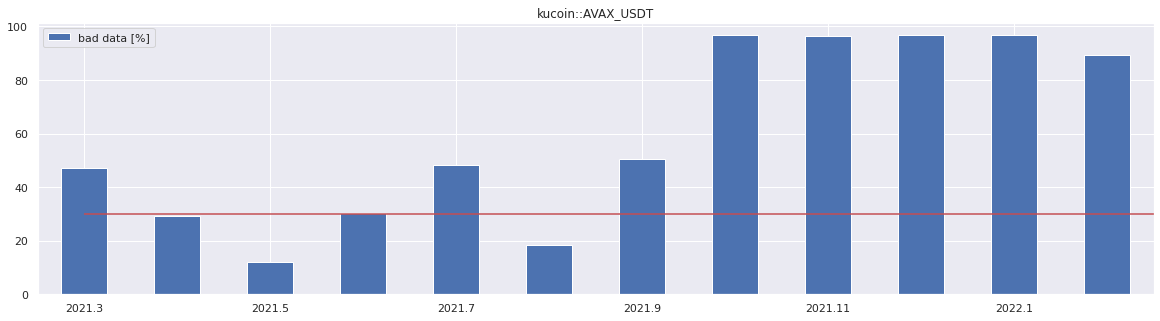

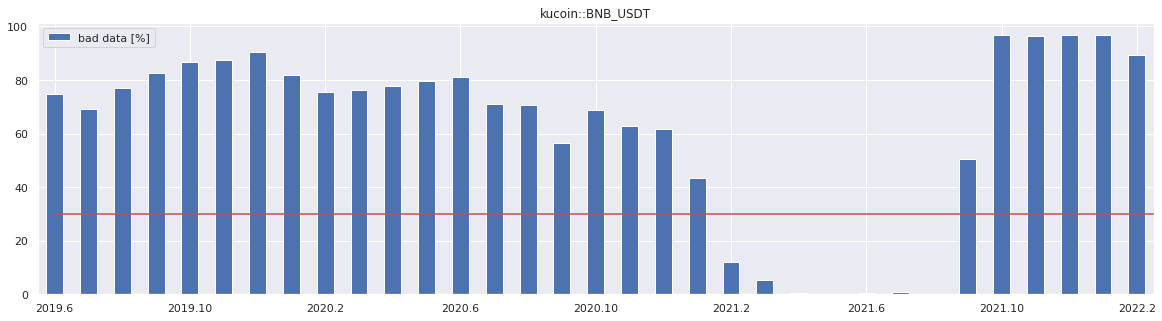

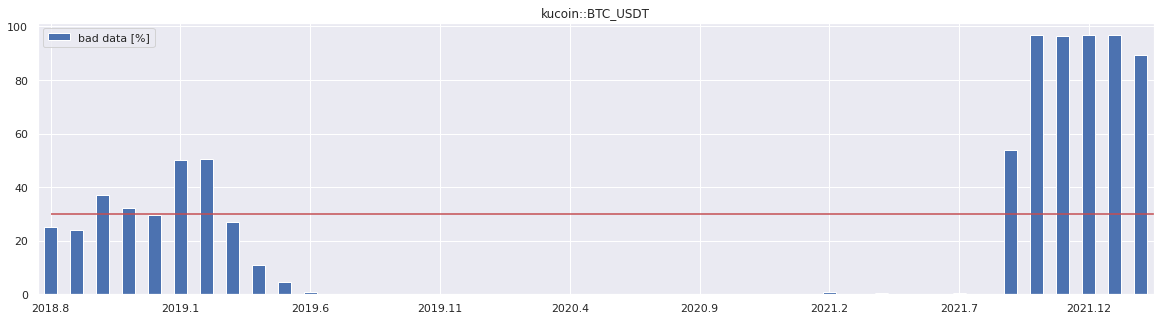

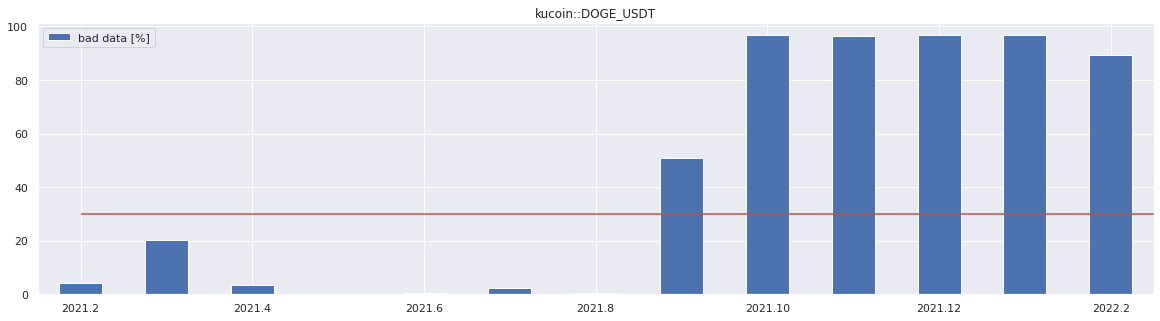

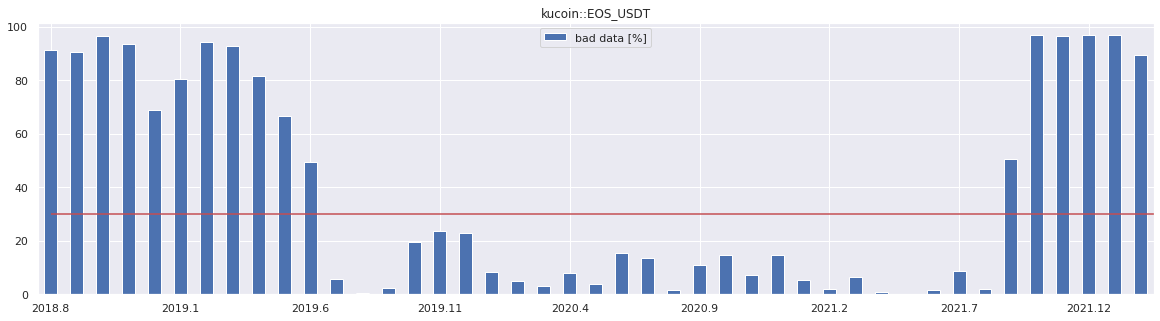

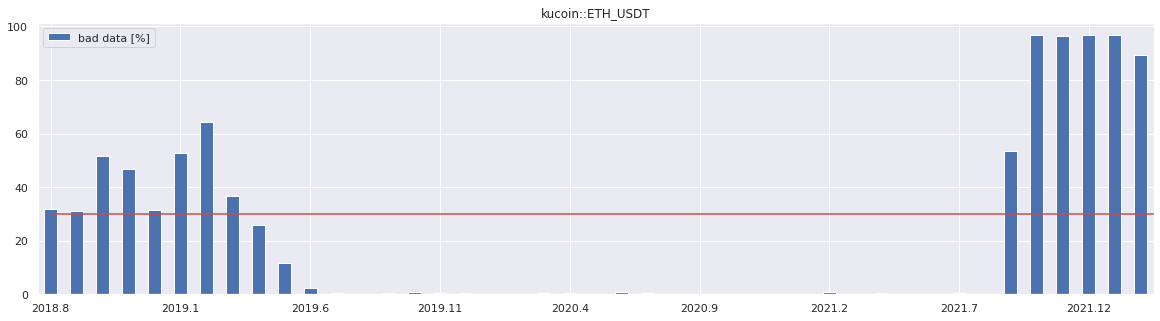

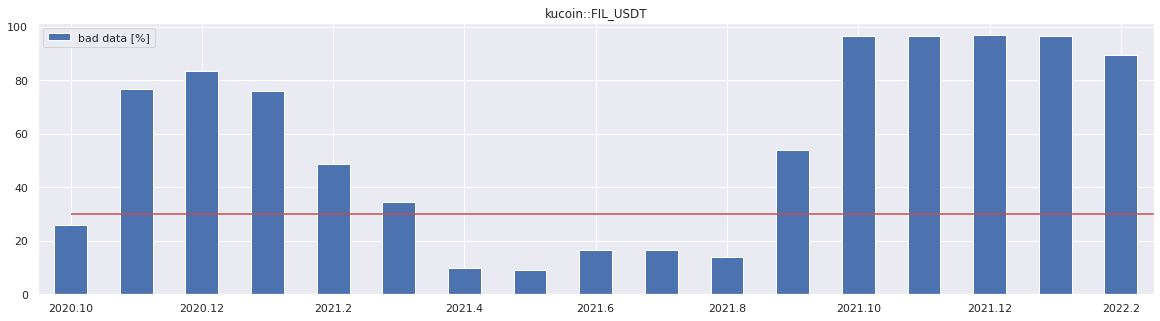

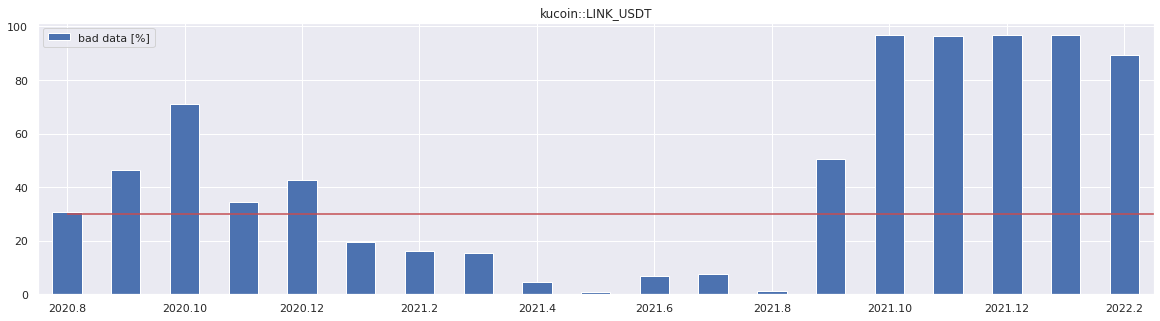

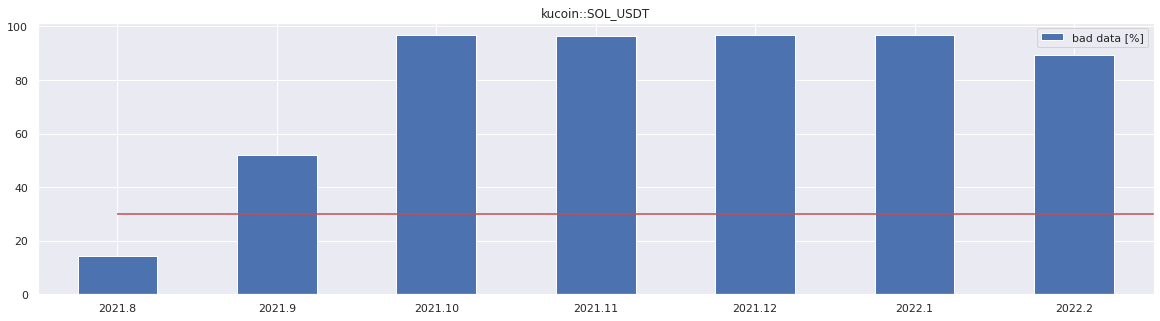

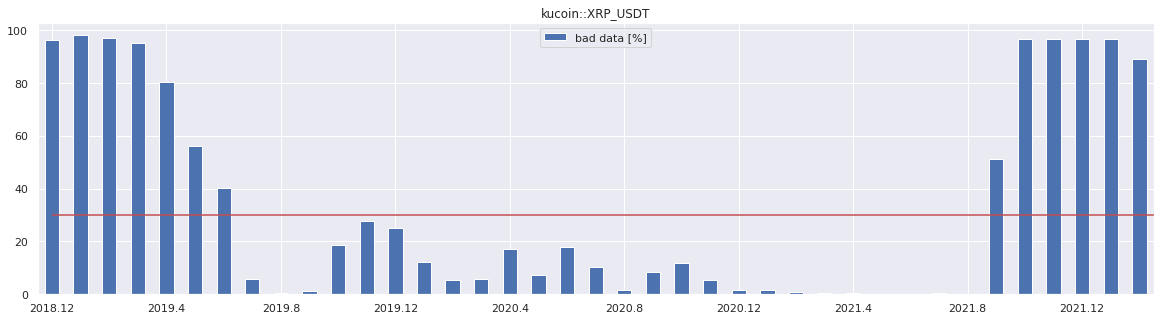

In [30]:
_ = ramccqa.plot_bad_data_by_year_month_stats(
    kucoin_bad_data_stats_by_year_month, config["stats"]["threshold"]
)